# 1. Introduction

This project will introduce the problem of Arabic Handwritten
Character Recognition (AHCR). And the goal of these kinds of issues is to translate handwritten text into machine-understandable text that is encoded by the machine.

Arabic writing is semi-cursive, which makes AHCR different from other languages in that it presents special difficulties. The automatic recognition of Arabic script becomes a challenging task because the Arabic alphabet consists of 28 characters, and each character can have multiple shapes depending on where it appears in a word. The project aims to introduce students to these issues and thoroughly teach them the methods necessary for efficient AHCR, especially making use of CNNs.

The two main goals of this project are to build a basic CNN for AHCR and investigate advanced ways to increase the accuracy of AHCR. These methods include utilizing data augmentation techniques to improve the generalizability of the model and studying different untrained or pre-trained models such as resnext50_32x4d.

# 2. Experimental setup and results


## 2.2 Loading and augmenting the data  

### 2.2.1. Loading the dataset

The dataset used is a dataset containing handwritten Arabic characters. With a total of 13440 image for training and 3360 for testing. The dataset containing a total of 28 class.  

For each class the theirs is different images to simulate different writing styles with an approximately 480 images for each class.

In [ ]:
import os
import re
import cv2
import glob
import json
import torch
import random
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from matplotlib import image
from torchvision import models
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.transforms.functional import gaussian_blur
from transformers import AutoImageProcessor, AutoModelForImageClassification

In [ ]:
! unzip Dataset

In [ ]:
def read_image_file(path):
    image_paths = glob.glob(path + "/*.png")
    image_data = []

    # Define the transformation to convert images to PyTorch tensors
    to_tensor_transform = transforms.ToTensor()

    for image_path in image_paths:
        img_name = os.path.basename(image_path)
        # Define a regular expression pattern to match the label number
        pattern = re.compile(r'label_(\d+)')
        # Use the findall method to extract all matches
        matches = pattern.findall(img_name)
        label_number = int(matches[0])

        # Read the image using OpenCV
        img = cv2.imread(image_path)

        if img is not None:
            # Apply the ToTensor transformation to convert the image to a PyTorch tensor
            img_tensor = to_tensor_transform(img)
            image_data.append((img_tensor, label_number))
        else:
            print(f"Error reading image: {image_path}")

    return image_data

In [ ]:
training_data  = read_image_file('/kaggle/input/ddddddddd/Dataset/Train Images 13440x32x32/train')
test_data = read_image_file('/kaggle/input/ddddddddd/Dataset/Test Images 3360x32x32/test')

### 2.2.2. Augmanting the dataset

For the data augmantation the following methodes were used.
 1. Rotating the images by random angles to simulate variations in the orientation of handwritten charecter.

 2. Adding noise to images, simulating pixel-level variations.

 3. Bluring the image, simulating the out-of-focus images

 4. changing both the brightness and contrast capture variations in lighting conditions.

In [ ]:
transform = transforms.Compose([
    transforms.RandomApply([transforms.RandomRotation(degrees=(-45, 45))], p=0.7),  # Rotate the images by random angles to simulate variations in the orientation of handwritten charecter.
    transforms.RandomApply([transforms.Lambda(lambda x: x + 0.05 * torch.randn_like(x))], p=0.3), # Adds noise to images, simulating pixel-level variations.
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.3), # Simulates out-of-focus or blurry images.
    transforms.RandomApply([transforms.ColorJitter(brightness=0.2, contrast=0.2)], p=0.4) # Adjust the brightness and contrast of the images randomly to capture variations in lighting conditions.
])

In [ ]:
augmented_training_data = []

for img, label in training_data:
  for i in range(0,3):
    augmented_image = transform(img)
    augmented_training_data.append((augmented_image,label))

In [ ]:
training_data2 = training_data + augmented_training_data

### 2.2.3. Displaying some samples of the data

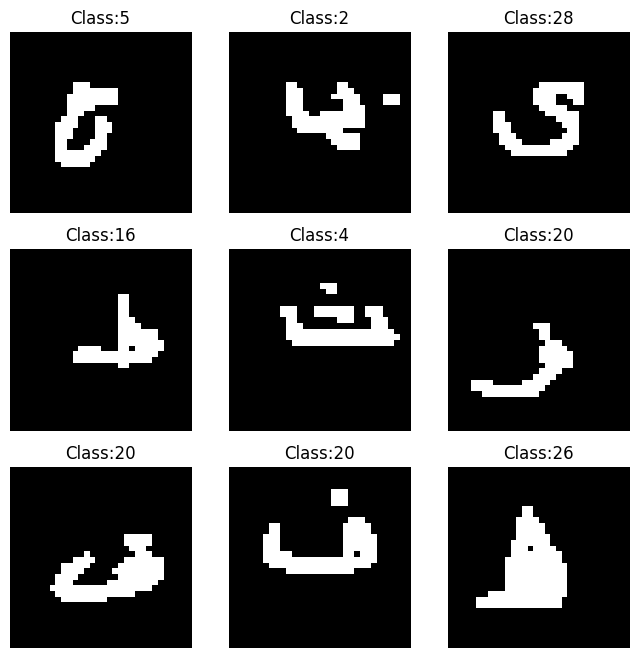

In [ ]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    if img.shape[0] == 1:
        img = img.squeeze()
    else:
        img = img.permute(1, 2, 0)
    figure.add_subplot(rows, cols, i)
    plt.title("Class:" + str(label))
    plt.axis("off")
    plt.imshow(img, cmap="gray")
plt.show()

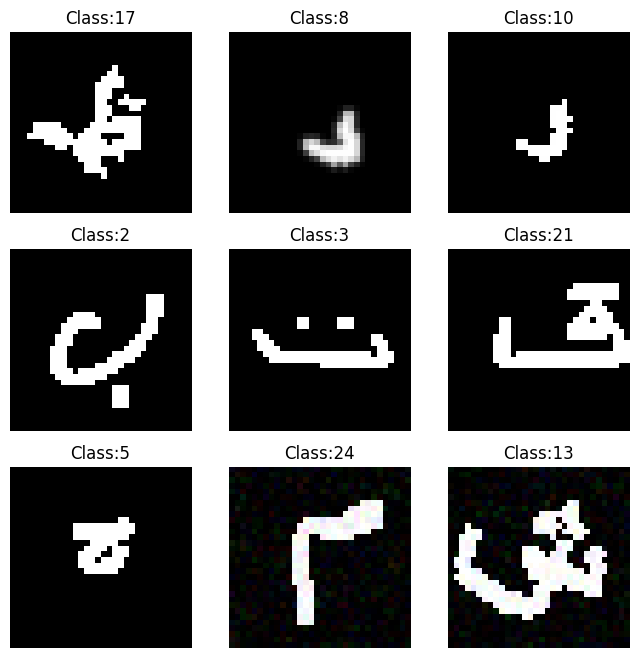

In [ ]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data2), size=(1,)).item()
    img, label = training_data2[sample_idx]
    if img.shape[0] == 1:
        img = img.squeeze()
    else:
        img = img.permute(1, 2, 0)
    figure.add_subplot(rows, cols, i)
    plt.title("Class:" + str(label))
    plt.axis("off")
    plt.imshow(img, cmap="gray")
plt.show()

### 2.2.4. evaluation methodology, evaluation metrics, and experimental setup.


The CNN networks were first trained on the training set of the data then it was evaluated using the testing\validation set of the data. This process was done for different epochs and for each epoch the training loss and accuracy as well as the testing loss and accuracy was printed and saved.

As for the evaluation metrics, the accuracy was used to indicate whether the model's prediction was correctly classified or not. The loss was also used to compare the model's performance.

For the experemintal setup, with the custom build CNN it was tested on both noraml data and augmanted data to compare between the two models and see the effect of aumantation on the models performance. After that a well-know CNN network was trained on the augmanted data with no pretraning done on the network and the results were compared with the first two parts. The last part a pretrained CNN network was selected and trained on the augmanted data to see the effect of pretraining the network.

for the training part Adam optimizer was chosen CrossEntropyLoss() for the loss function.

## 2.2. Custom CNN network for AHCR

### 2.2.1. building the CNN network

In [ ]:
class ArabicLettersCNN(nn.Module):
    def __init__(self):
            super(ArabicLettersCNN, self).__init__()
            self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
            self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
            self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
            self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
            # Max pooling layers
            self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
            # Dropout layers
            self.dropout1 = nn.Dropout(0.2)
            self.dropout2 = nn.Dropout(0.4)
            # Fully-connected layers
            self.fc1 = nn.Linear(128 * 2 * 2, 512)
            self.fc2 = nn.Linear(512, 512)
            self.fc3 = nn.Linear(512, 29)

    def forward(self, x):
            # Define the forward pass using the layers with shape printing
            x = self.pool(F.relu(self.conv1(x))) # output shape 16*16*16
            x = self.pool(F.relu(self.conv2(x))) # output shape 8*8*32
            x = self.dropout1(x)
            x = self.pool(F.relu(self.conv3(x))) # output shape 4*4*64
            x = self.pool(F.relu(self.conv4(x))) # output shape 2*2*128
            x = self.dropout2(x)
            x = x.view(x.size(0), -1) # output shape 2*2*128 = 512
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
            return x

### 2.2.2. Training the CNN networl

The training of the CNN network was done using 3 learning rates which are 0.1,0.01, and 0.001 with each learning rate being tested with three different epochs of 4,12, and 16 to conclude that a learning rate of 0.001 and epoch number of 16 gave the best results.

cuda:0

Epoch 1/16, Training Loss: 2.1467, Training Accuracy: 27.7679, Testing Loss: 1.2117, Testing Accuracy: 53.0000

Epoch 2/16, Training Loss: 1.0246, Training Accuracy: 62.6935, Testing Loss: 0.7199, Testing Accuracy: 75.0000

Epoch 3/16, Training Loss: 0.7683, Training Accuracy: 73.5491, Testing Loss: 0.5422, Testing Accuracy: 82.0000

Epoch 4/16, Training Loss: 0.6464, Training Accuracy: 78.8095, Testing Loss: 0.4430, Testing Accuracy: 84.0000

Epoch 5/16, Training Loss: 0.5652, Training Accuracy: 81.1235, Testing Loss: 0.3506, Testing Accuracy: 88.0000

Epoch 6/16, Training Loss: 0.4971, Training Accuracy: 83.7277, Testing Loss: 0.3873, Testing Accuracy: 87.0000

Epoch 7/16, Training Loss: 0.4717, Training Accuracy: 84.8438, Testing Loss: 0.3843, Testing Accuracy: 89.0000

Epoch 8/16, Training Loss: 0.4444, Training Accuracy: 85.9449, Testing Loss: 0.3244, Testing Accuracy: 90.0000

Epoch 9/16, Training Loss: 0.4242, Training Accuracy: 86.6295, Testing Loss: 0.3487, Testing Acc

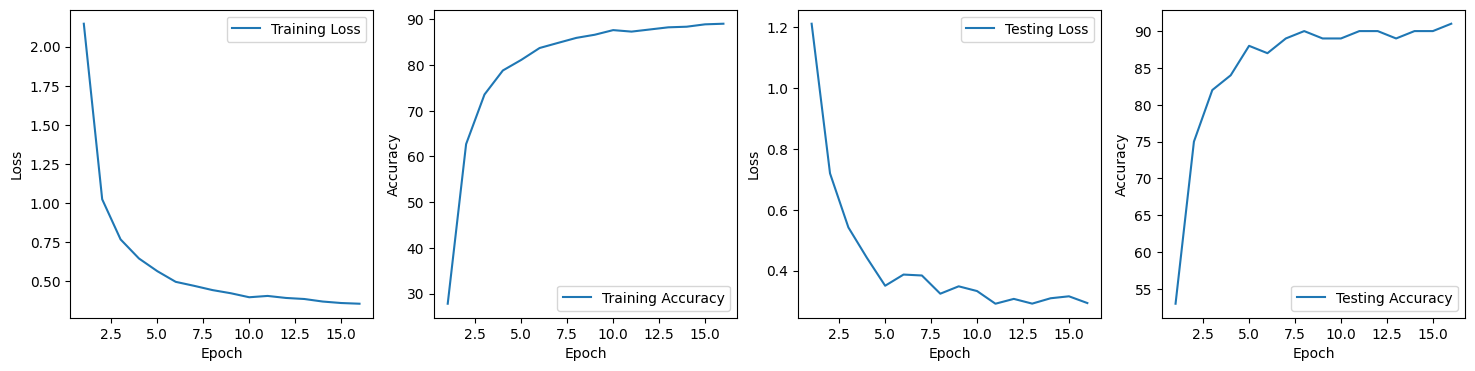

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

train_dataloader = DataLoader(training_data, batch_size=4, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=4, shuffle=True)

# Initializing the model, loss function, and optimizer
model = ArabicLettersCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Number of epochs
num_epochs = 16

# Lists to store metrics for plotting
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []


for epoch in range(num_epochs):
    # Training loop
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_train_loss = running_loss / len(train_dataloader)
    epoch_train_accuracy = 100 * correct_train / total_train

    # Test loop
    model.eval()
    with torch.no_grad():
      test_loss = 0.0
      correct_test = 0
      total_test = 0
      for data in test_dataloader:
          inputs, labels = data[0].to(device), data[1].to(device)

          outputs = model(inputs)

          loss = criterion(outputs, labels)

          test_loss += loss.item()

          _, predicted = torch.max(outputs.data, 1)
          total_test += labels.size(0)
          correct_test += (predicted == labels).sum().item()

      # calculate average testing loss
      average_test_loss = test_loss / len(test_dataloader)
      epoch_test_accuracy = 100 * correct_test // total_test

    # Append metrics to lists for plotting
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)
    test_losses.append(average_test_loss)
    test_accuracies.append(epoch_test_accuracy)

    # Print and/or log the metrics for each epoch
    print(f'Epoch {epoch + 1}/{num_epochs}, '
          f'Training Loss: {epoch_train_loss:.4f}, '
          f'Training Accuracy: {epoch_train_accuracy:.4f}, '
          f'Testing Loss: {average_test_loss:.4f}, '
          f'Testing Accuracy: {epoch_test_accuracy:.4f}')

# Plotting
plt.figure(figsize=(18, 4))

# Plot Training Loss
plt.subplot(1, 4, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Training  Accuracy
plt.subplot(1, 4, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Testing Loss
plt.subplot(1, 4, 3)
plt.plot(range(1, num_epochs + 1), test_losses, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Testing Accuracy
plt.subplot(1, 4, 4)
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

After the training process using the built ArabicLettersCNN, its clear that the CNN network gave ferly good results with the Top 1 Accuracy of the system being 91%.

## 2.3. Retraining the CNN network with data augmentation

cuda:0

Epoch 1/20, Training Loss: 1.4774, Training Accuracy: 51.7039, Testing Loss: 0.4746, Testing Accuracy: 84.0000

Epoch 2/20, Training Loss: 0.8355, Training Accuracy: 73.2366, Testing Loss: 0.3842, Testing Accuracy: 86.0000

Epoch 3/20, Training Loss: 0.7305, Training Accuracy: 76.8769, Testing Loss: 0.3646, Testing Accuracy: 88.0000

Epoch 4/20, Training Loss: 0.6954, Training Accuracy: 78.0673, Testing Loss: 0.3501, Testing Accuracy: 88.0000

Epoch 5/20, Training Loss: 0.6818, Training Accuracy: 78.9267, Testing Loss: 0.3056, Testing Accuracy: 90.0000

Epoch 6/20, Training Loss: 0.6542, Training Accuracy: 79.6577, Testing Loss: 0.3544, Testing Accuracy: 88.0000

Epoch 7/20, Training Loss: 0.6418, Training Accuracy: 80.1860, Testing Loss: 0.2729, Testing Accuracy: 92.0000

Epoch 8/20, Training Loss: 0.6410, Training Accuracy: 80.4148, Testing Loss: 0.3349, Testing Accuracy: 89.0000

Epoch 9/20, Training Loss: 0.6378, Training Accuracy: 80.5190, Testing Loss: 0.3219, Testing Acc

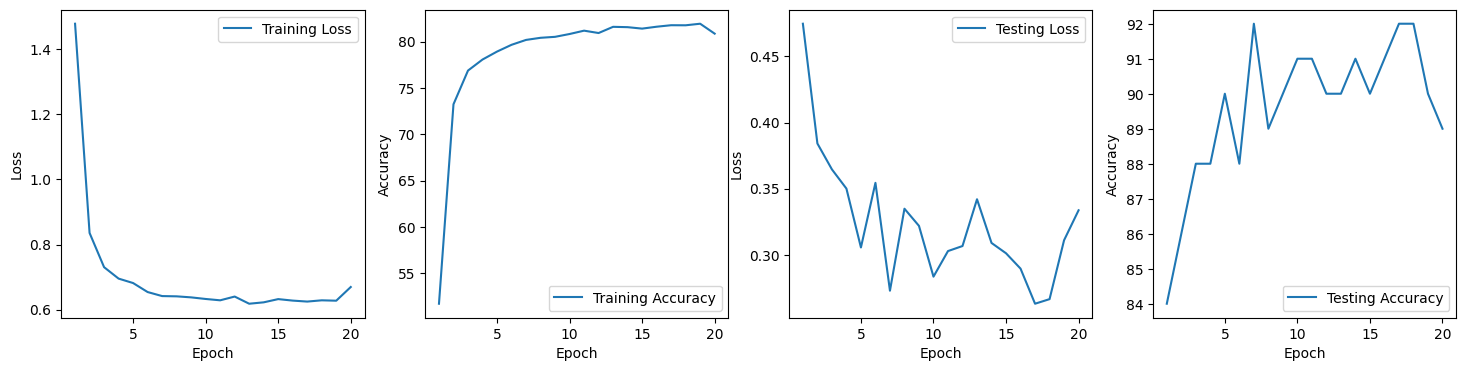

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

train_dataloader = DataLoader(training_data2, batch_size=4, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=4, shuffle=True)

# Initializing the model, loss function, and optimizer
model = ArabicLettersCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Number of epochs
num_epochs = 20

# Lists to store metrics for plotting
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []


for epoch in range(num_epochs):
    # Training loop
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_train_loss = running_loss / len(train_dataloader)
    epoch_train_accuracy = 100 * correct_train / total_train

    # Test loop
    model.eval()
    with torch.no_grad():
      test_loss = 0.0
      correct_test = 0
      total_test = 0
      for data in test_dataloader:
          inputs, labels = data[0].to(device), data[1].to(device)

          outputs = model(inputs)

          loss = criterion(outputs, labels)

          test_loss += loss.item()

          _, predicted = torch.max(outputs.data, 1)
          total_test += labels.size(0)
          correct_test += (predicted == labels).sum().item()

      # calculate average testing loss
      average_test_loss = test_loss / len(test_dataloader)
      epoch_test_accuracy = 100 * correct_test // total_test

    # Append metrics to lists for plotting
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)
    test_losses.append(average_test_loss)
    test_accuracies.append(epoch_test_accuracy)

    # Print and/or log the metrics for each epoch
    print(f'Epoch {epoch + 1}/{num_epochs}, '
          f'Training Loss: {epoch_train_loss:.4f}, '
          f'Training Accuracy: {epoch_train_accuracy:.4f}, '
          f'Testing Loss: {average_test_loss:.4f}, '
          f'Testing Accuracy: {epoch_test_accuracy:.4f}')

# Plotting
plt.figure(figsize=(18, 4))

# Plot Training Loss
plt.subplot(1, 4, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Training  Accuracy
plt.subplot(1, 4, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Testing Loss
plt.subplot(1, 4, 3)
plt.plot(range(1, num_epochs + 1), test_losses, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Testing Accuracy
plt.subplot(1, 4, 4)
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

After retraining the network using the augmented data it clear that this data improved the performance of the CNN network as the loss for the first ephoc was reduced from 2.1467 to 1.4774 due to the extra features added by the augmentation. It is also notable that the accuracy of the model on some ephocs has improved compared to the results on the normal data. Despite the starting with a higher training accuracy the network showed a smaller improvement compared to the network without augmentation which means that the Data augmentation seems to help generalization to some extent.

## 2.4. Training a well-known and published CNN architectures

for this part the resnext50_32x4d was chosen due to its high accuracy and low complexty architecture and modirated size of 50MB.

This model contains a total of 4 sequential layers followed by an average pooling layer and a fully connected layer for classification. The model showed an accuracy of 78% on the ImageNet dataset, the models also contains a total of 25.0289M parameters.

These sequential layers are designed to make the process of building and maintaining a model easier by placing the layers in the proper order for application during the forward pass. Additionally, each of these successive layers has set of bottleneck blocks, which aid in effective learning by lowering computational costs without compromising or even improving the network's representational capacity. In deep networks, it also aids with the vanishing gradient issue.

Most of these bottleneck block starts by reducing the number of channels (dimensionality reduction). Then the subsequent Batch Normalization layer normalizes the output.

Following the reduction of dimensionality, a bottleneck with 32 grouped convolutions is introduced by the second convolutional layer, which has a 3x3 kernel size. Given that capturing spatial features is the responsibility of this convolutional layer. Then the number of channels increases to 256 with the third convolutional layer, which has a 1x1 kernel size instead of 128. With this expansion, more intricate patterns can be captured. Lastly, a downsampling process is carried out to ensure that the input and output dimensions match. The input is converted from 64 channels to 256 channels using a sequential block that includes a 1x1 convolutional layer and batch normalization.

cuda:0
Epoch 1/20, Training Loss: 3.0487, Training Accuracy: 15.6008, Testing Loss: 3.1999, Testing Accuracy: 20.0000
Epoch 2/20, Training Loss: 2.5979, Training Accuracy: 21.6871, Testing Loss: 2.0200, Testing Accuracy: 45.0000
Epoch 3/20, Training Loss: 2.1417, Training Accuracy: 31.6220, Testing Loss: 1.8224, Testing Accuracy: 53.0000
Epoch 4/20, Training Loss: 1.6835, Training Accuracy: 45.0279, Testing Loss: 4.9949, Testing Accuracy: 62.0000
Epoch 5/20, Training Loss: 1.4543, Training Accuracy: 52.9241, Testing Loss: 11.9384, Testing Accuracy: 73.0000
Epoch 6/20, Training Loss: 1.2250, Training Accuracy: 60.3348, Testing Loss: 32.2333, Testing Accuracy: 73.0000
Epoch 7/20, Training Loss: 1.0546, Training Accuracy: 65.6585, Testing Loss: 55.7930, Testing Accuracy: 70.0000
Epoch 8/20, Training Loss: 0.9699, Training Accuracy: 68.3092, Testing Loss: 50.9725, Testing Accuracy: 81.0000
Epoch 9/20, Training Loss: 0.8685, Training Accuracy: 71.7094, Testing Loss: 108.4107, Testing Accura

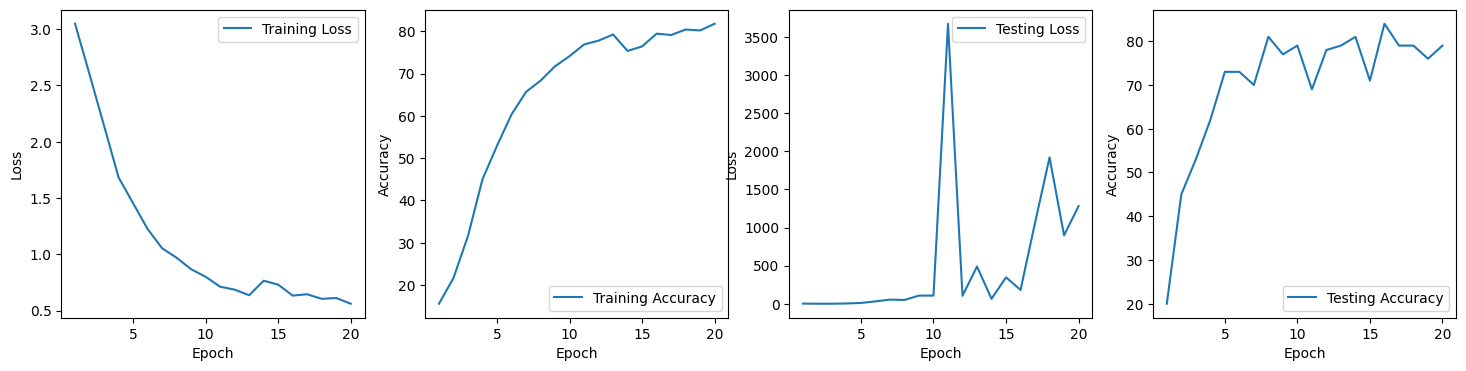

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

train_dataloader = DataLoader(training_data2, batch_size=4, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=4, shuffle=True)

# Initializing the model, loss function, and optimizer
model = models.resnext50_32x4d()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 29)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Number of epochs
num_epochs = 20

# Lists to store metrics for plotting
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []


for epoch in range(num_epochs):
    # Training loop
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_train_loss = running_loss / len(train_dataloader)
    epoch_train_accuracy = 100 * correct_train / total_train

    # Test loop
    model.eval()
    with torch.no_grad():
      test_loss = 0.0
      correct_test = 0
      total_test = 0
      for data in test_dataloader:
          inputs, labels = data[0].to(device), data[1].to(device)

          outputs = model(inputs)

          loss = criterion(outputs, labels)

          test_loss += loss.item()

          _, predicted = torch.max(outputs.data, 1)
          total_test += labels.size(0)
          correct_test += (predicted == labels).sum().item()

      # calculate average testing loss
      average_test_loss = test_loss / len(test_dataloader)
      epoch_test_accuracy = 100 * correct_test // total_test

    # Append metrics to lists for plotting
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)
    test_losses.append(average_test_loss)
    test_accuracies.append(epoch_test_accuracy)

    # Print and/or log the metrics for each epoch
    print(f'Epoch {epoch + 1}/{num_epochs}, '
          f'Training Loss: {epoch_train_loss:.4f}, '
          f'Training Accuracy: {epoch_train_accuracy:.4f}, '
          f'Testing Loss: {average_test_loss:.4f}, '
          f'Testing Accuracy: {epoch_test_accuracy:.4f}')

# Plotting
plt.figure(figsize=(18, 4))

# Plot Training Loss
plt.subplot(1, 4, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Training  Accuracy
plt.subplot(1, 4, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Testing Loss
plt.subplot(1, 4, 3)
plt.plot(range(1, num_epochs + 1), test_losses, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Testing Accuracy
plt.subplot(1, 4, 4)
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

With a training loss of 3.0487 more than the training loss attained in the first two parts—the resnext50_32x4d network produced less encouraging results than the one employed in the first two sections. It's also noteworthy that the network performs best during the first four epochs before beginning to overfit during the remaining epochs, which explain the rise in testing loss.

## 2.5. Using a pre-trained CNN network

Since the model for this part was pretrained on imageNet that contains at least 3 million images the transfer learning used is to use the pretrained network as a feature extraction network, freezing the hidden layers parameters, then adding some fully connected layers after the hidden layers.

cuda:0
Epoch 1/12, Training Loss: 1.6716, Training Accuracy: 51.1830, Testing Loss: 1.7888, Testing Accuracy: 77.0000
Epoch 2/12, Training Loss: 0.8982, Training Accuracy: 75.8910, Testing Loss: 0.7689, Testing Accuracy: 84.0000
Epoch 3/12, Training Loss: 0.6779, Training Accuracy: 82.2693, Testing Loss: 0.3807, Testing Accuracy: 90.0000
Epoch 4/12, Training Loss: 0.5783, Training Accuracy: 85.1339, Testing Loss: 0.6670, Testing Accuracy: 87.0000
Epoch 5/12, Training Loss: 0.4980, Training Accuracy: 87.3996, Testing Loss: 0.3185, Testing Accuracy: 91.0000
Epoch 6/12, Training Loss: 0.4465, Training Accuracy: 88.8579, Testing Loss: 0.3192, Testing Accuracy: 91.0000
Epoch 7/12, Training Loss: 0.4019, Training Accuracy: 89.8642, Testing Loss: 0.4080, Testing Accuracy: 92.0000
Epoch 8/12, Training Loss: 0.3646, Training Accuracy: 90.7440, Testing Loss: 0.2580, Testing Accuracy: 93.0000
Epoch 9/12, Training Loss: 0.3629, Training Accuracy: 91.0751, Testing Loss: 3.2890, Testing Accuracy: 89

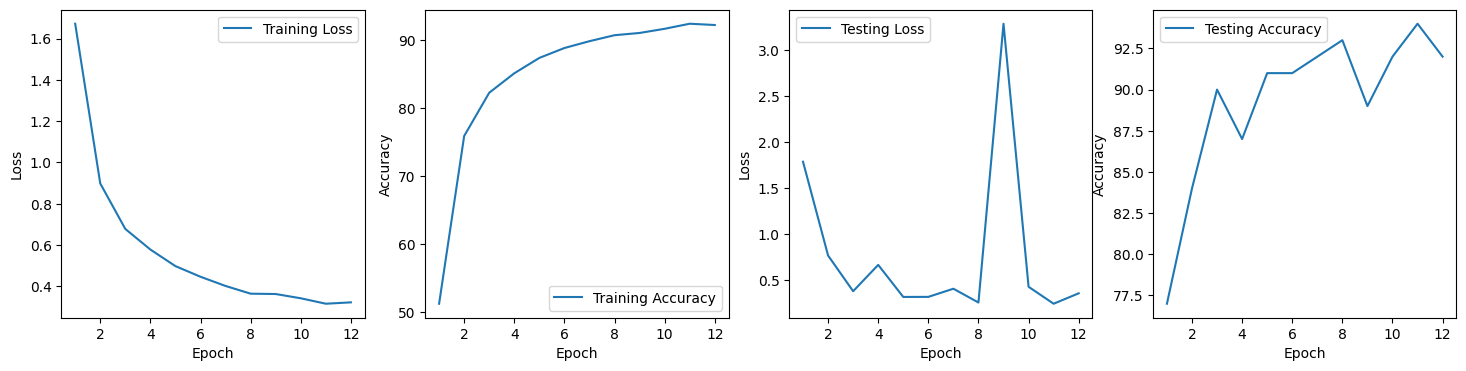

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

train_dataloader = DataLoader(training_data2, batch_size=4, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=4, shuffle=True)

# Initializing the model, loss function, and optimizer
model = models.resnext50_32x4d(weights='IMAGENET1K_V2')

num_features = model.fc.in_features

hidden_layers = [nn.Linear(num_features, 1024),
                 nn.ReLU(),
                 nn.Dropout(0.5)]

fc_layers = [nn.Linear(1024, 512),
             nn.ReLU(),
             nn.Dropout(0.5),
             nn.Linear(512, 256)]

new_classifier = nn.Sequential(*hidden_layers, *fc_layers)

model.fc = new_classifier

model.avgpool2 = torch.nn.AdaptiveAvgPool2d(output_size=(1, 1))

model.fc2 = torch.nn.Linear(256, 29)

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Number of epochs
num_epochs = 12

# Lists to store metrics for plotting
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []


for epoch in range(num_epochs):
    # Training loop
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_train_loss = running_loss / len(train_dataloader)
    epoch_train_accuracy = 100 * correct_train / total_train

    # Test loop
    model.eval()
    with torch.no_grad():
      test_loss = 0.0
      correct_test = 0
      total_test = 0
      for data in test_dataloader:
          inputs, labels = data[0].to(device), data[1].to(device)

          outputs = model(inputs)

          loss = criterion(outputs, labels)

          test_loss += loss.item()

          _, predicted = torch.max(outputs.data, 1)
          total_test += labels.size(0)
          correct_test += (predicted == labels).sum().item()

      # calculate average testing loss
      average_test_loss = test_loss / len(test_dataloader)
      epoch_test_accuracy = 100 * correct_test // total_test

    # Append metrics to lists for plotting
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)
    test_losses.append(average_test_loss)
    test_accuracies.append(epoch_test_accuracy)

    # Print and/or log the metrics for each epoch
    print(f'Epoch {epoch + 1}/{num_epochs}, '
          f'Training Loss: {epoch_train_loss:.4f}, '
          f'Training Accuracy: {epoch_train_accuracy:.4f}, '
          f'Testing Loss: {average_test_loss:.4f}, '
          f'Testing Accuracy: {epoch_test_accuracy:.4f}')

# Plotting
plt.figure(figsize=(18, 4))

# Plot Training Loss
plt.subplot(1, 4, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Training  Accuracy
plt.subplot(1, 4, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Testing Loss
plt.subplot(1, 4, 3)
plt.plot(range(1, num_epochs + 1), test_losses, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Testing Accuracy
plt.subplot(1, 4, 4)
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

With a testing accuracy of 94.00%, the modified pretrained resnext50_32x4d achieves the highest of all the tested networks. Additionally, its initial training accuracy was rather high, and over the course of the training epochs, it continuously improves its testing and training accuracies.